In [3]:
!pip install timm

In [4]:
import os
import spacy
import timm
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset

In [5]:
!nvidia-smi

Tue Mar 23 09:54:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class Vocabulary():
    def __init__(self, freq_threshold, spacy_en):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold
        self.spacy_en = spacy_en

    def __len__(self):
        return len(self.itos)

    def tokenizer_en(self, text):
        return [tok.text.lower() for tok in self.spacy_en.tokenizer(text)]

    def build_vocab(self, sentences):
        frequencies = {}
        i = 4
        for sentence in sentences:
            for word in self.tokenizer_en(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = i
                    self.itos[i] = word
                    i += 1

    def numericalize(self, text):
        tokens = self.tokenizer_en(text)
        return [self.stoi[t] if t in self.stoi else self.stoi["<unk>"] for t in tokens]

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform, spacy_en, freq_threshold):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold, spacy_en)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        img = self.transform(img)
        num_caption = [self.vocab.stoi["<sos>"]]
        num_caption += self.vocab.numericalize(caption)
        num_caption.append(self.vocab.stoi["<eos>"])
        num_caption = torch.tensor(num_caption)
        return img, num_caption

In [8]:
class CollateFn():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [b[0].unsqueeze(0) for b in batch]
        imgs = torch.cat(imgs, dim=0)
        captions = [b[1] for b in batch]
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return imgs, captions

In [9]:
class Encoder(nn.Module):
    def __init__(self, pretrained_encoder_model, hidden_size):
        super().__init__()
        self.vit = timm.create_model(pretrained_encoder_model, pretrained=True)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.vit.head = nn.Linear(self.vit.head.in_features, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        features = self.vit(x)
        return self.relu(self.dropout(features))

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, hidden_size, p=0.1):
        super().__init__()
        assert hidden_size % n_heads == 0, "hidden_size must be divisble by n_heads!!"
        self.n_heads = n_heads
        self.hidden_size = hidden_size // n_heads
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(3)])
        self.out_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout1 = nn.Dropout(p=p)
        self.dropout2 = nn.Dropout(p=p)
        
    def forward(self, x, mask=None):
        # x: b, t, d
        # mask: b, h, t, t
        b = x.shape[0]
        queries, keys, values = x, x, x
        # d = h*d'
        # b, t, d -> b, h, t, d'
        queries, keys, values = [fc(x).view(b, -1, self.n_heads, self.hidden_size).transpose(1, 2).contiguous() for fc, x in zip(self.fc_layers, (queries, keys, values))]
        # queries & keys: b, h, t, d'
        # att: b, h, t, t
        att = (queries @ keys.transpose(-2, -1).contiguous()) / (keys.shape[-1] ** 0.5)
        if mask != None:
            att = att.masked_fill(mask==0, float("-inf"))
        att = att.softmax(dim=-1)
        att = self.dropout1(att)
        # values: b, h, t, d'
        # x: b, h, t, d'
        x = att @ values
        # b, h, t, d' -> b, t, d
        x = x.transpose(1, 2).contiguous().view(b, -1, self.n_heads * self.hidden_size)
        return self.dropout2(self.out_layer(x))

In [11]:
class Block(nn.Module):
    def __init__(self, n_heads, hidden_size, p=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.attn = SelfAttention(n_heads, hidden_size, p=p)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.GELU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(p=p),
        )

    def forward(self, x, mask):
        x = x + self.attn(self.ln1(x), mask=mask)
        x = x + self.mlp(self.ln2(x))
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_len, n_layers, n_heads, p=0.1):
        super().__init__()
        self.max_len = max_len
        self.hidden_size = hidden_size
        self.tok_emb = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.pos_emb = torch.zeros(max_len, hidden_size).float()
        self.pos_emb.requires_grad = False
        pos = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = 1 / (10000 ** (torch.arange(0, hidden_size, 2).float() / hidden_size))
        self.pos_emb[:, 0:int(hidden_size/2)] = torch.sin(pos * div_term)
        self.pos_emb[:, int(hidden_size/2):] = torch.cos(pos * div_term)
        self.pos_emb = self.pos_emb.unsqueeze(0)
        self.embed_dropout = nn.Dropout(p=p)
        
        self.register_buffer("mask", torch.tril(torch.ones(max_len, max_len)).view(1, 1, max_len, max_len))
        self.blocks = nn.ModuleList([Block(n_heads, hidden_size, p) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions=None):
        if captions == None:
            assert self.max_len >= 1, "token size exceeded max_len!! increase max_len"
        else:
            assert captions.shape[1] + 1 <= self.max_len, "token size exceeded max_len!! increase max_len" # "+ 1" represents the features' token
        
        if captions == None:
            if len(features.shape) == 2:
                x = features.unsqueeze(1)
            else:
                x = features
        else:
            if len(features.shape) == 2:
                features = features.unsqueeze(1)
            embed_caps = self.tok_emb(captions)
            x = torch.cat((features, embed_caps), dim=1)
        
        x += self.pos_emb[:, :x.shape[1], :].to(x.device)
        x = self.embed_dropout(x)
        token_size = x.shape[1]
        mask = self.mask[:, :, :token_size, :token_size].to(x.device)
        for block in self.blocks:
            x = block(x, mask)
        return self.fc_out(x)

In [13]:
class Net(nn.Module):
    def __init__(self, pretrained_encoder_model, vocab_size, hidden_size, max_len, n_layers, n_heads, p=0.1):
        super().__init__()
        self.encoder = Encoder(pretrained_encoder_model, hidden_size)
        self.decoder = Decoder(vocab_size, hidden_size, max_len, n_layers, n_heads, p=0.1)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        out = self.decoder(features, captions)
        return out

    def caption_image(self, image, vocab, max_len=50, device="cpu"):
        caption = []
        with torch.no_grad():
            features = self.encoder(image).unsqueeze(1) # 1, d -> 1, 1, d
            captions = None
            for _ in range(max_len):
                out = self.decoder(features=features, captions=captions).squeeze(0) # 1, t, d -> t, d
                prediction = out.argmax(-1)[-1] # t, d -> t -> t[-1]
                caption.append(prediction.item())
                captions = torch.tensor([caption]).to(device)
                if vocab.itos[prediction.item()] == "<eos>":
                    break
        return [vocab.itos[i] for i in caption]

In [14]:
def get_mean_and_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim = [0, 2, 3]) # 1 -> channel dimension
        channels_squared_sum += torch.mean(data ** 2, dim = [0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5 
    return mean, std

In [15]:
# dummy_data = CustomDataset("flickr8k/images/", "flickr8k/captions.txt", inf_transform, spacy_en, freq_threshold)
# pad_idx = dummy_data.vocab.stoi["<pad>"]
# dummy_loader = DataLoader(dummy_data, batch_size=128, num_workers=2, shuffle=True,
#                     pin_memory=True, collate_fn=CollateFn(pad_idx=pad_idx))
# mean, std = get_mean_and_std(dummy_loader)
# print(mean, std)

In [16]:
image_size = 224
scale = 1.4
scaled_size = int(scale * image_size)
mean = [0.4582, 0.4463, 0.4041]
std = [0.2694, 0.2622, 0.2771]
spacy_en = spacy.load("en")
freq_threshold = 3
train_transform = transforms.Compose(
    [
     transforms.Resize((scaled_size, scaled_size)), 
     transforms.RandomCrop((image_size, image_size)), 
     transforms.RandomApply(
         [
          transforms.RandomRotation(50.0)
         ], p=0.4
     ),
     transforms.RandomApply(
         [
          transforms.GaussianBlur(3)
         ], p=0.3
     ),
     transforms.ToTensor(), 
     transforms.Normalize(mean, std)
    ]
)

inf_transform = transforms.Compose(
    [
     transforms.Resize((image_size, image_size)),
     transforms.ToTensor()
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40455 torch.Size([3, 224, 224]) torch.Size([10]) tensor([ 1,  4, 49, 47, 91,  3, 15, 48,  5,  2])


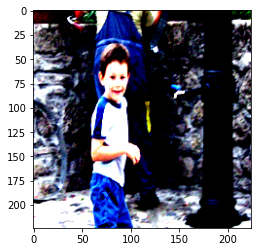

In [17]:
data = CustomDataset("flickr8k/images/", "flickr8k/captions.txt", train_transform, spacy_en, freq_threshold)
img, cap = data[42]
print(len(data), img.shape, cap.shape, cap)
plt.imshow(img.permute(1, 2, 0))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_encoder_model = "vit_small_patch16_224"
epochs = 10
batch_size = 128
vocab_size = len(data.vocab)
hidden_size = 1024
max_len = 512
n_layers = 20
n_heads = 16
lr = 2.5e-4
print(device, vocab_size)

cuda 4093


In [19]:
pad_idx = data.vocab.stoi["<pad>"]
loader = DataLoader(data, batch_size=batch_size, num_workers=2, shuffle=True, 
                    pin_memory=True, collate_fn=CollateFn(pad_idx=pad_idx))

In [20]:
x, y = next(iter(loader))
x.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 26]))

In [21]:
net = Net(pretrained_encoder_model, vocab_size, hidden_size, max_len, n_layers, n_heads).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=data.vocab.stoi["<pad>"])
optimizer = torch.optim.Adam(net.parameters(), lr)
scaler = torch.cuda.amp.GradScaler()

In [22]:
def save_model(net, optimizer, filename):
    checkpoint = {"net_dict": net.state_dict(), "optimizer_dict": optimizer.state_dict()}
    torch.save(checkpoint, filename)
    print("model saved!!\n")

def load_model(net, optimizer, filename, device="cpu"):
    checkpoint = torch.load(filename, map_location=device)
    net.load_state_dict(checkpoint["net_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_dict"])
    print("model loaded!!\n")

In [23]:
def CaptionImage(net, image, data, max_len, transform, device="cpu"):
    net.eval()
    img = transform(Image.open(image).convert("RGB")).unsqueeze(0)
    words = net.caption_image(img.to(device), data.vocab, max_len, device)
    caption = ""
    for w in words:
        caption += w + " "
    print(caption)

In [24]:
CaptionImage(net, "test_images/dog.jpg", data, 50, inf_transform, device)

brindle barks pale same gray tropical overweight licked dome breaks happily double same doors double chalkboard recording cheeks speaker bicyclists boxers gathers grasses double chalkboard recording range cargo tide recording clinging <eos> 


In [25]:
def loop(net, loader):
    net.train()
    losses = 0
    for imgs, captions in tqdm(loader, total=len(loader)):
        imgs = imgs.to(device)
        captions = captions.to(device)
        with torch.cuda.amp.autocast():
            out = net(imgs, captions[:, :-1])
            loss = loss_fn(out.view(-1, out.shape[2]), captions.view(-1))
        losses += loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return losses/len(loader)

In [26]:
images = ["dog.jpg", "child.jpg", "boat.jpg", "elon_musk.jpg", "street.jpg"]
best_loss = float("inf")
for epoch in range(epochs):
    loss = loop(net, loader)
    print(f"epoch: {epoch} | loss: {loss:.4f}")
    for image in images:
        CaptionImage(net, f"test_images/{image}", data, 50, inf_transform, device)
    print("")
    if loss < best_loss:
        best_loss = loss
        save_model(net, optimizer, "best_model.pth.tar")

100%|██████████| 317/317 [13:32<00:00,  2.56s/it]


epoch: 0 | loss: 3.8925
<sos> a brown and white dog is running through a snowy forest . <eos> 
<sos> a person taking a bicycle off a rock wall . <eos> 
<sos> a person taking a jump off a rock wall . <eos> 
<sos> a person wearing a black outfit and white helmet is standing in a black outfit and red and black outfit . <eos> 
<sos> a person taking a bicycle down a steep hill . <eos> 



  0%|          | 0/317 [00:00<?, ?it/s]

model saved!!



100%|██████████| 317/317 [09:24<00:00,  1.78s/it]


epoch: 1 | loss: 2.6225
<sos> a dog is jumping in the air to catch a stick . <eos> 
<sos> a boy in a blue jacket is riding a toy . <eos> 
<sos> a man is kayaking on the ground by a body of water . <eos> 
<sos> a man in a brown jacket is sitting on the ground . <eos> 
<sos> a man is riding a bicycle on the side of a road . <eos> 



  0%|          | 0/317 [00:00<?, ?it/s]

model saved!!



100%|██████████| 317/317 [09:29<00:00,  1.80s/it]


epoch: 2 | loss: 2.3276
<sos> a dog walks on a beach with a person in the foreground . <eos> 
<sos> a young boy wearing a red shirt is holding a toy . <eos> 
<sos> a person in a red and blue outfit is sliding down a slide . <eos> 
<sos> a man wearing a hat and sunglasses is standing in front of a building . <eos> 
<sos> a person in a red jacket and hat stands next to a building . <eos> 



  0%|          | 0/317 [00:00<?, ?it/s]

model saved!!



100%|██████████| 317/317 [09:23<00:00,  1.78s/it]


epoch: 3 | loss: 2.1195
<sos> a dog running on the beach . <eos> 
<sos> a little boy is wading through the pool . <eos> 
<sos> a man is riding a boat on calm water . <eos> 
<sos> a man in a tuxedo and tie is holding a book . <eos> 
<sos> a group of people stand together on a railing . <eos> 



  0%|          | 0/317 [00:00<?, ?it/s]

model saved!!



  2%|▏         | 6/317 [00:11<10:14,  1.98s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-8de8ab7f72f1>", line 4, in <module>
    loss = loop(net, loader)
  File "<ipython-input-25-56d9ae8b4229>", line 4, in loop
    for imgs, captions in tqdm(loader, total=len(loader)):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1104, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1182, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1138, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

KeyboardInterrupt: ignored

In [28]:
# model collapses if it goes below a loss of 2
load_model(net, optimizer, "best_model.pth.tar")

model loaded!!



In [29]:
for image in images:
    CaptionImage(net, f"test_images/{image}", data, 50, inf_transform, device)

<sos> a dog running on the beach . <eos> 
<sos> a little boy is wading through the pool . <eos> 
<sos> a man is riding a boat on calm water . <eos> 
<sos> a man in a tuxedo and tie is holding a book . <eos> 
<sos> a group of people stand together on a railing . <eos> 
